In [1]:
!echo "Y" | pip uninstall compact

Found existing installation: compact 0.0.1
Uninstalling compact-0.0.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/compact-0.0.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/compact/*
Proceed (Y/n)?   Successfully uninstalled compact-0.0.1


# Starter Kit: Contextual Performance Profiling and Anomaly Detection

In [2]:
!pip install -r https://raw.githubusercontent.com/rpverbek/compact-sk/main/compact/requirements.txt
try:
    # running on colab
    from google.colab import output
    output.enable_custom_widget_manager()
except ModuleNotFoundError:
    # running locally
    display("Not running in Google Colab, skipping the Colab-specific code.")

  Cloning https://github.com/rpverbek/compact-sk.git to /tmp/pip-install-hn8k7h9m/compact_c558f970c0054c4d8c7fa3a1a2898e6c
  Running command git clone --filter=blob:none --quiet https://github.com/rpverbek/compact-sk.git /tmp/pip-install-hn8k7h9m/compact_c558f970c0054c4d8c7fa3a1a2898e6c
  Resolved https://github.com/rpverbek/compact-sk.git to commit 0850e00d69863f3234945d7b01348591bd7c688c
  Preparing metadata (setup.py) ... done
  Created wheel for compact: filename=compact-0.0.1-py3-none-any.whl size=18727 sha256=903c1ccd910e66c16c24dfa8867ad39e90aebeebe9a0bd4f860c3f8e8959ff76
  Stored in directory: /tmp/pip-ephem-wheel-cache-xh1dgqk7/wheels/48/d8/b8/17146e928a2f52859d3e797229cc8b3b1ec39d5ba9593a668b
Successfully built compact

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


'Not running in Google Colab, skipping the Colab-specific code.'

In [3]:
%load_ext autoreload
%autoreload 2
# The autoreload can be removed at the end?
from compact.data.phm_data_handler import fetch_and_unzip_data
from compact.nmf_profiling import extract_nmf_incremental, get_df_W_offline_and_online
from compact.nmf_profiling import get_pivot_table
from compact.viz.viz import illustrate_nmf_components_interactive, show_fingerprints, plot_example_interactive
from compact.viz.viz import plot_ROC_curve, plot_weights_interactive
from compact.util import get_operating_modes
from compact.preprocessing import get_and_preprocess_healthy_data, get_and_preprocess_unhealthy_data
import seaborn as sns

from IPython.display import Markdown as md

# ignore convergence warnings (1000 iterations reached by NMF)
import warnings;
warnings.filterwarnings('ignore');



> ToDo: make clear that Anomaly Detection and Performance Profiling has their own code section.


## Business context
Industry 4.0 leverages on the advanced AI technologies to enable anomaly detection and performance profiling of industrial assets operating in different contexts. Context is defined by both internal and external factors, such as operational conditions, environmental variables, and usage patterns. For this reason, context-aware methods are fundamental to identify anomalies and to ensure accurate and reliable asset profiling. These methods allow for real-time monitoring and enable enhanced performance and reduce downtime of assets. <mark> FFNG: We are introducing the term "anomaly" only in the background section, but mention it already in here. Shouldn't we explain it already briefly beforehand? </mark>

## Business goal

The business goal related to this Starter Kit (SK) is to illustrate a data-driven methodology to identify anomalies and profile the performance of assets operating in different contexts, i.e., in terms of process measurements reflecting the internal operations of the asset.
As data-driven methodology, this SK focuses on the methodology developed by Fingerhut et al. [[1](#fingerhut2023), [2](fingerhut2024)]. Conventional anomaly detection methods often detect anomalies when the operating conditions change, rendering them less applicable for real-world dynamic industrial use cases. In contrast, the methodology presented in this starterkit is suitable for these scenarios, because it considers the dynamic nature of operating conditions.


## Application contexts

Contextual anomaly detection and performance profiling play a relevant role in a variety of industrial contexts such as:

- Raise warnings to anticipate and avoid safety-critical conditions
- Alert the need for inspection to avoid possible downtime and cost corrective maintenance
- Performance benchmarking

## Data characteristics and requirements
To showcase the SK, a dataset is required that includes:

- The vibration frequency captured by asset sensors. The captured vibrations need to be related to the health state of the assets.
- Parameters related to the internal operations of the asset that influence the vibrations but are not necessarily directly related to the health state.  <mark> FFNG: Added "that influence [...]" </mark>.

## Starter Kit outline


The SK is organized in five main sections. First, the required background knowledge is provided to understand the terminology used in the rest of the document. Second, a description of data generated by the assets along with its preprocessing is reported. Third, the methodology introduced by [Fingerhut et al. [1]](#fingerhut2023) is illustrated highlighting how it can be used for performance profiling. Fourth, the validation of the methodology for anomaly detection is provided. Finally, conclusions are drawn.

At the end of the SK you will know how to:

- Develop a model for anomaly detection and performance profiling

- Experimentally validate the resulting model


## 1. Background
  
- **anomaly**: A data point that deviates significantly from what is expected under the given conditions. Anomalies give an indication about potential failures of the asset. <mark> FFNG: Added some explanation in potential failures </mark>
- **operating mode**. An asset can operate in different contexts which can influence its behavior. We refer to these context-dependent behaviors as operating modes. As an example we can imagine a gearbox that operates in two modes: normal and throttle. These two modes can be isolated by analzying the context, specifically the rotation speed of the gears. In throttle mode, the gearbox would operate under a reduced load, which would be indicated by a low rotational speed.
- **operating and performance views**. The operating view is composed of the parameters capturing the operating context (e.g. rotation speed, torque). The performance view is composed of the parameters monitoring the performance behaviour (e.g. vibrations).

## 2. Data understanding

### 2.1 Data description

The dataset we will use in this Starter Kit comes from the [PHM North America challenge '23](https://data.phmsociety.org/phm2023-conference-data-challenge/). This dataset collects the time series data from a gearbox subject to pitting, i.e. a fatigue failure of the gear tooth along with metadata. This dataset includes measurements under varied operating conditions, defined in terms of rotational speed and torque, from a healthy state as well as six known fault levels. The training data are collected from a range of different operating conditions under 15 different rotational speeds and 6 different torque levels.  For each operating condition, 5 vibration measurements were collected.
The vibration data is given in the time domain with a sampling rate of 20480Hz. The sampling duration differs between 3 and 12 seconds. For each vibration measurement there are tri-axial time-domain vibration measurements available (x, y and z). The vibrations are collected at different rotation per minute (rpm) and different runs.  Below, the user can get acquainted with the dataset by visualizing the vibration measurements in the three directions (x, y and z) for different rpm and runs. 



<img src="https://data.phmsociety.org/wp-content/uploads/sites/9/2023/06/PHM2023dc_fig1.png" alt="MarineGEO circle logo" style="height: 375px; width:800px;"/>

In [4]:
# Fetch the data if necessary
fetch_and_unzip_data()

'../data/Data_Challenge_PHM2023_training_data'

In [5]:
# Fetch the data if necessary
fetch_and_unzip_data()

'../data/Data_Challenge_PHM2023_training_data'

In [6]:
plot_example_interactive()

interactive(children=(Dropdown(description='Chose the context', layout=Layout(width='60%'), options=(('RMP 100…

### 2.2 Preprocessing

Splitting the dataset into training and testing sets is a common activity for validating the machine learning models. The training dataset is used to prepare a model, i.e. to train it, whereas the testing dataset is used to evaluate the performance of the model.
In our case, the training and the testing set are based on splitting the vibration measurements. More specifically, a random sample of 75% of the original data recorded under normal (= healthy) condition is used for training whereas the remaining 25% is used for testing.  In the rest of the document, we will only refer to this split to analyze the performance of the methodology for the sake of the computational time. However, to have more reliable results, multiple splits should be performed, i.e. multiple random samples should be extracted for the training and testing sets. The interested reader can refer to [Fingerhut et al. [2]](#fingerhut2024) to see the results when 100 random splits are generated.



The testing set is then created by combining:
1. **Normal condition**: The 25% healthy data that was held back (not used in the training set)
2. **Anomaly condition**: Vibration data characterized by pitting level 1-8 (two more than in the training set). For each level of pitting, there are between 267 and 304 samples in the test set that were recorded at different speeds and torques.

The figure below illustrates the train-test split.

<img src="https://github.com/rpverbek/compact-sk/blob/main/work/figures/overview_train-test-split.png?raw=1" alt="Overview train-test split" style="width:1000px;"/>

Furthermore, from the test set are removed operating conditions (i.e. combinations of rotational speed and torque) which did not appear in the training set (this can happen if during the random train-test split all measurements with the same operating conditions end up only in the test set).

As the next step, the original data in the training set is prepared for the analysis.
- The **time series data** is transformed into frequency-bands. Typically, a frequency-band characterize the vibration behaviour in a specific range of frequencies (measured in Hertz [Hz]). We refer to a frequency-band in terms of "order". It is worth to notice that a frequency measure captures the number of events per second whereas the "order" captures the number of events per revolution of the rotating element. Finally, a order-transformation is applied to standardize the data. This step is important and a common preprocessing step for prognostics and health management analysis. For details, the interested reader is referred to the vibration alignment section of [Fingerhut et al. [1]](#fingerhut2023). All order-transformed vibration measurements are organized in a matrix which we call **performance matrix V**.
- Metadata is created from the original dataset. The metadata contains the parameters at which the vibrations were measured:
    - The **torque** expresses the rotational force in terms of Newton meter.
    - The **rotation speed** expresses, how fast the gearbox is rotating in terms of revolutions per minute.
    - It additionally hosts information aboute the **measurement direction** (x, y and z) and the **sample ids**, to be able to differentiate beteween multiple measurements at the same rotation speed and torque.

    <mark> AMUR > Fabian, the metadata table hosts more information than the one reported in the bullet points above FFNG: Added bulletpoint with additional information. </mark>

A brief excerpt of the **performance matrix V** is shown below.

In the performance matrix V, all order-transformed vibration measurements are organized in a matrix, where each column contains a frequency band which is two orders long. The exact lenght of the order-transformed frequency band was determined beforehand based on the smotheness of the signal, but it can be adapted as a hyperparameter. The first column gives the total amplitude between 0.5 and 2.5 orders. <mark> FFNG: Added explanation of V here.</mark>

In [7]:
# Here we need something to showcase how the training and testing dataset looks like (columns, their meaning, etc)
df_V_train, meta_data_train, df_data_healthy_test, f = get_and_preprocess_healthy_data()
df_orders_test, meta_data_test = get_and_preprocess_unhealthy_data(df_data_healthy_test, f)

# extract list of frequency band columns for later usage
cols_ = df_V_train.columns
BAND_COLS = cols_[cols_.str.contains('band')].tolist()

df_V_train.head()

,band_0.5-2.5,band_2.5-4.5,band_4.5-6.5,band_6.5-8.5,band_8.5-10.5,band_10.5-12.5,band_12.5-14.5,band_14.5-16.5,band_16.5-18.5,band_18.5-20.5,...,band_80.5-82.5,band_82.5-84.5,band_84.5-86.5,band_86.5-88.5,band_88.5-90.5,band_90.5-92.5,band_92.5-94.5,band_94.5-96.5,band_96.5-98.5,band_98.5-100.5
index,,,,,,,,,,,,,,,,,,,,,
0,0.000083,0.001135,0.000332,0.000749,0.001604,0.001779,0.002436,0.000905,0.003705,0.000203,...,0.002588,0.004577,0.005826,0.001566,0.003492,0.019335,0.006759,0.009075,0.004589,0.005449
1,0.000030,0.000419,0.000701,0.000212,0.000586,0.000226,0.000414,0.000210,0.000723,0.000209,...,0.003337,0.007597,0.015687,0.003851,0.010378,0.018125,0.005149,0.002389,0.001015,0.001774
2,0.000092,0.000264,0.000134,0.000106,0.001203,0.000446,0.018651,0.012879,0.029916,0.006926,...,0.010886,0.011106,0.026134,0.009216,0.017948,0.095809,0.018065,0.016754,0.004955,0.003817
3,0.001093,0.000285,0.000084,0.000135,0.000072,0.000105,0.000596,0.002880,0.000250,0.000562,...,0.039877,0.013978,0.009773,0.006686,0.010765,0.014013,0.009631,0.006961,0.002484,0.007278
4,0.001949,0.000557,0.000211,0.000272,0.000150,0.000162,0.000396,0.009223,0.000645,0.002202,...,0.016658,0.007494,0.015543,0.010917,0.013567,0.012068,0.006568,0.004345,0.002025,0.003673


The matrix above has n columns which represent vibration measurements and m rows which represent the order-transformed frequency bands.

    AMUR > Fabian, the refernece to "frequency bins" just falls from the sky. Is this the same as frequency bands?. Introduce in the section above this term. E.g. "All order-transformed vibration measurements are organized in a matrix" where XXX is organized in frequency bins and YYY is organized in band ranges. Or something similar. FFNG: Added information before cell.

Next, we illustrate the corresponding metadata, consisting of the previously described process parameters `rotational speed [RPM]` and `torque [Nm]`, and some additional information regarding the vibration measurement direction (`direction`). Each row corresponds to the same row in the performance matrix. For instance, the very first measurement contains vibrations recorded at 3000 RPM and 50 NM, for the vibration measurement direction x.

    AMUR > Fabian, the sentence above is not true right? I don't see 300 NM. FFNG: the order must have in the meantime? I adapted.
    AMUR > Fabian, what\s the point of showing sample id and unique sample id? Does it carry information useful for the SK which follows? or conversely, why they were created? To map operational parameters with keywords which you eventually use to map with the matrix V? FFNG: It was previously used for the mapping. At the moment I am not sure anymore. I hide it from the output for the time being.

In [8]:
meta_data_train.drop(columns=['sample_id', 'unique_sample_id']).head()

,rotational speed [RPM],torque [Nm],direction
0,3000,50,psd_x
1,3000,50,psd_y
2,3000,50,psd_z
3,400,100,psd_x
4,400,100,psd_y


In the use case, a finite number of combinations of speed and torque values are present. These combinations of process parameters, characterizing the behavior of the gearbox, describe the **operating modes** of the asset. ~~In this use case, the operating modes are 76.~~ <mark> Fabian: **Can we remove the last sentence that I just striked through and the following code cell?** Later we repeat this discussion in "Extracting operating modes" stating that there are 77 instead of 76 operating modes. This is due to one operating mode not containing any measurements, which is counted when we state that there are 77 operating mode and not counted when there are 76 operating modes. </mark>
<a id='number-of-oms'></a>

In [9]:
n_oms = len(meta_data_train['unique_sample_id'].str[:-2].unique())
display(md(f'There are {n_oms} unique operating modes.'))

There are 76 unique operating modes.

## 3. Methodology

The methodology can be divided into the offline and online phases. The offline phase focuses on performance profiling. More specifically, the operating modes of healthy assets are extracted and mapped to the expected performances. The online phase focuses on anomaly detection by exploiting the performance profiles extracted in the previous phase.


### 3.1 Offline phase

The general workflow of the offline phase is reported in the figure below.

    AMUR> Fabian, the figure mentions: process sensor meausurement.  This name is never used before. What is it? What you call process parameters? If the latter, update the figure accordingly. Same applies to performance sensor measurement and vibration amplitude. What is it? Please, check that there is a mapping with the terms in the figure and text (ctrl+F, ctrl+C and ctrl+V for each term you are not sure is actually used or meaningful) FFNG: Replaced figure. Need to push to github.

<img src="https://github.com/rpverbek/compact-sk/blob/main/work/figures/overview_offline-phase.png?raw=1" alt="Overview offline phase" style="width:800px;"/>


This phase can be divided into 3 steps (See Figure above). The main goals of these phases can be summarized as follow:
1. Characterizing performance  behaviour. High-dimensional vibration signals are characterized in terms of a few vibration components that capture the fundamental vibration behaviour.
2. Extracting operating modes. Based on the process parameters, the operating modes are extracted and associated with each measurement. In the original methodology, a measurement is taken at a specific timestamp. The gearbox dataset does not contain information about the point in time when a measurement was taken.

    AMUR > Fabian, in section Extracting operating modes there is no reference to 'timestamp'. Can you go to that section and add at least one sentence which mentions them? FFNG: Changed "timestamp" to "measurement" and added clarification later in the text, that this part can be adapted to timeseries data.

3. Linking operating modes to performance behaviour. For each operating mode a performance fingerprint is associated.



#### Characterizing performance behaviour

In this step, we extract for each asset its characteristic **performance behaviour**. These behaviours are extracted by applying a _non-negative matrix factorization_ (NMF) [[3](#nmf)] to the performance matrix V. 
We apply NMF to decompose the matrix V into a separate weight matrix $\mathbf{W}$ and a component matrix $\mathbf{H}$, i.e., $\mathbf{V} \approx \mathbf{W} \times \mathbf{H}$. The latter two matrices are lower-dimensional matrices and the approximation contains the essential information about the asset's performance. Hence, NMF reveals underlying patterns in the performance data by representing it in a simpler form.

Compared to other decomposition and dimensionality reduction methods (such as PCA or auto-encoders), NMF has the advantage that it decomposes the vibrations into entirely positive values. This is important for interpretability, because non-negative factors correspond to real-world quantities that cannot take negative values, such as the frequency transformed vibrations. As a result, the components in $\mathbf{H}$ can be understood in combination with the weights in $\mathbf{W}$ as additive combinations. This makes it easier to understand how the vibrations contribute to the overall performance behavior.
    
> AMUR> Fabian, I don't see why a matrix with only positive values is 'interpretable'. Or I don't understand what make a matrix interpretable. Either remove the sentence, either explain what you meant.
>
> FFNG: Added some explanation. If you don't agree, we can delete it. But I think it has certain advantages over for instance PCA or auto-encoders.
>
> RVEB: the explanation makes sense to me.

The component matrix $\mathbf{H}$ contains a set of $h$ representative components allowing to express performance behaviour in a standardized way and thus allowing to compare performance across operating modes and across assets. The matrix $\mathbf{W}$ contains the weights for reconstructing the original performance matrix $\mathbf{V}$. Each element in $\mathbf{W}$ can be interpreted as the weights of the building blocks in $\mathbf{H}$ needed to reconstruct a vibration signal encoded in the performance matrix $\mathbf{V}$.

To decide the value $h$ of components we decompose the matrix multiple times using an increasing number of components. In the next code section, we apply the NMF to up to 50 components.

In [10]:
MAX_N_COMPONENTS = 50    # maximum number of components used to recompute

df_nmf_models = extract_nmf_incremental(df_V_train, max_n_components=MAX_N_COMPONENTS, timestamps=df_V_train.index, verbose=True)

Fitting NMF with varying number of components: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


Below, we illustrate the decomposition of the performance matrix V.

    AMUR> Fabian, what is vibration data? Can you just refer to the matrix you want to decompose? FFNG: Changed. The following sentences further describe the visualisation.

The identification of the number of components to describe the operating context is not trivial. To facilitate this process, in the plot below we provide the following plots.
- The top two plots visualize how well the performance matrix $\mathbf{V}$ can be approximated
    - The left-top plot illustrates the cumulative explained variance of a principal component analysis (PCA) of the performance matrix $\mathbf{V}$. It merely serves as an indication of an upper bound for how well the signal could be expressed using PCA.
    - The top-righ plot illustrates the reconstruction error of the performance matrix $\mathbf{V}$ using the NMF components. The reconstruction error is calculated as the Frobenius norm of the difference between the original matrix and the reconstructed matrix.
- The bottom lineplots illustrate the NMF components.

In the interactive widget below, the reader can select how the number of components are determined. This number can be based on:

- a threshold for the cumulative _explained variance_ from PCA (e.g., 95%). In this case, the smallest number of components for which this threshold is exceeded, is selected.
- the reconstruction error plot. In this case, the _knee point_ is identified and used to determine the number of components. The identification of this knee point is an extension of the methodology presented in [2] for automated hyperparameter tuning for operative context detection.
- both the aforementioned methods. In this case the highest of the two values is used as the number of components.

Each of the $h$ components from $\mathbf{H}$ is illustrated in a separate lineplot. The components serve as building blocks of the observed vibration signals, revealing common patterns in the vibration measurements.

For the suggested settings, it can be observed that components 1 and 2 form the basis vectors for peaks that are observed at 40 and 80 orders. These peaks are expected, as the driving gear has 40 teeth. It is common to see peaks for multiples of the number of teeth, hence there is also a peak at 80 orders. Components 3, 4 and 5 encode smaller peaks which model the noise floor.

The reader is invited to experiment with multiple parameters below to verify how they affect the number of components extracted. The domain expert can use this code section to incorporate their domain knowledge to make the extraction and representation of implicit contexts more data-efficient .

The interactive widget allows to go beyond the analysis performed in the original methodology [[2](#fingerhut2024)]. By increasing the range of acceptable components or by increasing the threshold (in case of using the explained variance as criterium)
    
> AMUR: Robbert, what does it mean 'increase' the selection criteria?! The selection criteria are in drp down list. What does it mean: increase?
>
> RVEB: fixed.

, more components will be used in the decomposition. This makes the vibration fingerprints more granular, but also more prone to noise. In contrast, decreasing the accepted range or the selection criterium will yield less components, making the resulting fingerprints less informative, but also less prone to noise.

The number of components should be neither too low, which would lead to inaccurate and too general vibration fingerprints, nor should it be too high, which would lead to too specific fingerprints which could model the noise.

In [11]:
saved_values = illustrate_nmf_components_interactive(df_V_train, df_nmf_models)

interactive(children=(Dropdown(description='How to select the number of components for NMF', layout=Layout(wid…

We proceed with the number of components determined in the interactive figure above.

In [12]:
N_COMPONENTS = saved_values['n_components']
COMPONENT_COLUMNS = list(range(N_COMPONENTS))  # used later
model = df_nmf_models[(df_nmf_models.n_components == N_COMPONENTS)].iloc[0]
plural = 's' if N_COMPONENTS > 1 else ''
display(md(f"We are using **{N_COMPONENTS} component{plural}**."))

We are using **5 components**.

> AMUR: Robbert: At the end of this section, the reader played with the number of components. Did we test multiple options? Should we not put a limit to avoid that the notebook breaks?
>
> RVEB: Tested for both extreme cases (n_components = 1 and very large). Figures also adapt automatically to remain as readable as possible.

While the starterkit is able to cope with different hyperparameters, in the text that follows, we assume that 5 components were chosen.

#### Extracting operating modes.

This step focuses in context-segmentation of context-dependent behaviors of the assets; in other words, this section highlights how the operating modes of the asset are extracted. In this use case, the extraction of the operating modes is straightforward since it maps with the possible combinations of rotational speed and torque.  
For clarity, in the text that follows, the operating modes are reported using the pattern `@ X rpm, Y Nm`, where `X` corresponds to the rotational speed and `Y` corresponds to the torque. All measurements with the same rotational speed and torque are summarized in the same operating mode (OM). There are as many operating modes, as there are unique combinations of `X` and `Y`.

Note that, while in the starter kit, operating modes are extracted independently of the time, it is possible to adapt the operating mode extraction to time-series data, where time spans are assigned a specific operating mode, instead of single measurements. <mark> FFNG: Added this brief clarification. </mark>

In [13]:
df_operating_modes = get_operating_modes()
df_operating_modes

,100,200,300,400,500,600,700,800,900,1000,1200,2100,2700,3000,3600
50,OM 1,OM 2,OM 3,OM 4,OM 5,OM 6,OM 7,OM 8,OM 9,OM 10,OM 11,OM 12,OM 13,OM 14,OM 15
100,OM 16,OM 17,OM 18,OM 19,OM 20,OM 21,OM 22,OM 23,OM 24,OM 25,OM 26,OM 27,OM 28,OM 29,OM 30
200,OM 31,OM 32,OM 33,OM 34,OM 35,OM 36,OM 37,OM 38,OM 39,OM 40,OM 41,OM 42,OM 43,OM 44,
300,OM 45,OM 46,OM 47,OM 48,OM 49,OM 50,OM 51,OM 52,OM 53,OM 54,OM 55,OM 56,,,
400,OM 57,OM 58,,OM 59,OM 60,OM 61,OM 62,OM 63,OM 64,OM 65,OM 66,,,,
500,OM 67,OM 68,OM 69,OM 70,OM 71,OM 72,OM 73,OM 74,OM 75,OM 76,OM 77,,,,


The pivot table above depicts the names of the extracted operating modes in function of the two process parameters speed and torque. For example, an asset running in `OM 1` (top left) runs at a rotational speed of 100 rpm and a torque of 50 Nm, whereas an asset running in `OM 77` (bottom right) runs at 1200 rpm and 500 Nm. For this train-test split, there is a total of 77 operating modes.

#### <a id='Link-operating-modes-to-performance-behaviour'></a>Linking operating modes to performance
In this step, the performance behaviour is linked with the operating modes. This allows to derive **context-sensitive performance fingerprints**. As each vibration measurement is assigned to an operating mode, it is possible to derive fingerprints by aggregating all rows in $\mathbf{W}$ annotated with the same operating mode.
In the following, for each of the 77 operating modes, the reader can visualize the performance behaviour for each individual measurement based on the selected statistics (e.g. mean).
Note that for the 77 operating modes, not all of them will have measurements in the training set. These operating modes will therefor not have a fingerprint, which explains why the number of operating modes mentioned at [the end of section 2 ](#number-of-oms) can be lower than 77.

<mark> FFNG: Added that operating mode 28 has no meaurements, and therefore also no fingerprint. </mark>

> RVEB: I reworded it to make it more generic. On my own laptop, the split was different, resulting in only 73 OMs.

In [14]:
show_fingerprints(model, df_V_train, meta_data_train, df_operating_modes)

interactive(children=(Dropdown(description='Select the operating mode', layout=Layout(width='60%'), options=((…

The heat map reports the strength (color) of the weights of the vibration components (cf. NMF component illustration above, x-axis) for the three different directions (y-axis).
The weights of the vibration components, which span from 0 to 0.343, are evalued in terms of power spectral density (PSD).

    AMUR> Fabian, is correct the sentence above? I refactored your text. Can you also replace XXX? FFNG: replaced.
    
The PSD is a representation of how the power of the signal is distributed across different frequency components, providing insight into the dominant frequencies present in the vibration data over time.

From the analysis of the operating modes, it is possible to observe that they present distinct performance fingerprints, as can be observed for instance when comparing operating mode (OM) 1 with OM 50. Whereas OM 1 predominantly expresses vibrations in the third component related to the noise floor for all vibration directions, OM 50 predominantly expresses vibrations in the first two components related to 40 and 80 orders. At the same time, operating modes with similar operating conditions show similar vibration fingerprints. For instance, OM 1 and OM 16 only differ slightly in the torque, which results (as expected) in similar vibration fingerprints.

At the end of this offline phase, each operating mode has its own performance profile

### 3.2 Online phase

The general workflow of the online phase is reported in the figure below. Note that due to the nature of the data used in this use case, some steps are no longer necessary or become very simplified. These steps are still included for the sake of completeness.

<img src="https://github.com/rpverbek/compact-sk/blob/main/work/figures/overview_online-phase.png?raw=1" alt="Overview online phase" style="width:800px;"/>

This phase can be divided in five steps (See Figure above). The main goals of these phases can be summarized as follows:

4. **Windowing incoming streaming**. Streaming data is usually divided into batches. This activity is generally performed to avoid processing each new received data point as it arrives. However, in our use case there no streaming data, for this reason windowing is not needed and this step is skipped.

5. **Detecting of the operating context**. Each timestamp is associated with an operating mode which was identified during the offline phase. In this use case, operating modes are linked to vibration measurements without timestamps.

    AMUR > Fabian, do we need or not timestamps? If not, make it clear in the offline phase too. For instance write: In this use case, operating modes are not associated to timestamps but only to ... FFNG: We don't need timestamps in the starterkit. I changed the text in the offline phase accordingly. 

6. **Deriving the performance profiles**. Each vibration measurement is characterized in terms of the vibration components that were extracted in the first step of the offline phase.

7. **Estimating the fingerprint offset**. For each vibration measurement, the _offset_ is calculated between the online profiles and the offline fingerprints. The offset quantifies to what extent the observed vibration behaviour differs from the expected vibration behaviour expressed through the fingerprints.

8. **Deriving alarms**. In the original paper [[2](#fingerhut2024)], based on the offset, an anomaly score is computed for each timestamp. This score is monitored over time to trigger alarms. In this use case, the monitoring of the anomaly score is not possible since the timestamps in the test set are not ordered. For this reason, this step is skipped.


#### Detecting of the operating context and deriving the performance profiles.

As in the offline phase, the operating modes are extracted from each timestamp present in the testing dataset. Then, the performance profiles are derived for each vibration measurement.

The goal of extracting the performance profiles is to capture and represent the key characteristics of the vibration signal in a way that reflects the asset's vibration behavior. Therefore, this step essentially mirrors the step 1 of the offline phase, with the exception that the vibration components are not derived again.

The performance profiles approximate the vibration signal in terms of the representative vibration components that were extracted during step 1 of the offline phase. Similarly to this step, the approximation contains the essential information about the asset's performance.
These profiles are extracted by applying NMF to the processed vibration measurements from the online phase, denoted as $\mathbf{v}'$.
The processed measurements $\mathbf{v}'$ are a vector with the same number of elements as the columns in the performance matrix $\mathbf{V}$. Since the step is applied to a data stream, multiple samples are no longer stacked together as in $\mathbf{V}$ during the offline phase.

In the online phase, NMF now uses the $h$ components from matrix $\mathbf{H}$, which were already identified during the offline phase. Specifically, NMF decomposes $\mathbf{v}'$ into a weight vector $\mathbf{w}'$ using the fixed component matrix $\mathbf{H}$, such that $\mathbf{v}' \approx \mathbf{w}' \times \mathbf{H}$.

Since the same components are used from the offline phase, the profiles match the format of the vibration fingerprints, making them suitable for subsequent anomaly detection steps.

In [15]:
df_W_offline, df_W_online, fingerprints, test_vibration_measurement_periods_meta_data = get_df_W_offline_and_online(df_V_train, meta_data_train, meta_data_test, model, df_orders_test)

To better understand the derived weights $\mathbf{w}'$, below the derived weights for a single measurement are illustrated.
A vibration measurement consists of the three measurements directions (namely the x-, y- and z-axis, corresponding to the rows in the colormap below).
The weights that are illustrated below consist of $h$ columns each, where $h$ represents the number of components determined in the offline phase.
The format of the weights is the same as that of the fingerprint shown in the [previous section](#Link-operating-modes-to-performance-behaviour).

    AMUR> Fabian, before you reported psd_x, etc. Now, the psd is gone from the matric below. Is this correct? FFNG: I changed the code in the viz.viz.show_fingerprints such that it should give as y-axis ticks "x" instead of "psd_x". Note that, because the compact module is downloaded and installed from github, the changes in compact modules will only come into effect, once we push the code to github. We will need to check, whether this will be actually the case.

In [16]:
plot_weights_interactive(df_W_online, meta_data_test, df_operating_modes, N_COMPONENTS)

interactive(children=(Dropdown(description='Select measurement', layout=Layout(width='60%'), options=((0, 0), …

As an example, we select measurement 10 from the test set, which was taken at 1000 rpm and 50 Nm and therefore corresponds to operating mode 10. It can be observed that components 1 and 4 have high values in all 3 measurement directions.

> AMUR> Fabian, the dropdown section asks: period. What is a period? This was never mentioned before. Find a place to mention it (before the table) FFNG: Added 'As vibrations measurements are taken over time, we refer to them as "period".' Alternatively, we could rename the dropdown menu to "which measurement" @Robbert, what do you think?
>
> RVEB: Changed to "select measurement" and removed the explanation for period in the text, since it's no longer needed.

When comparing this to the vibration fingerprint at OM 10 (see the [interactive widget for showing the fingerprints](#Link-operating-modes-to-performance-behaviour) and choose operating mode 10), we observe a similar behaviour. Hence, for this example, the observed beahviour is similar to the expected vibration behaviour, which is indicative that this vibration measurement can be considered as non-anomalous. This comparison is a representative example on how to check whether the vibration measurement is indicative of an anomaly.

At the end of this step, for each online vibration measurement, a performance profile is extracted, which is of the same format as the vibration fingerprints.
The performance profile contains the essential information of the vibration signal, while being of the same format as the vibration fingerprints.

In the next section, the performance profiles are compared to the expected vibrations from the fingerprints in an automated fashion.

#### Estimating the fingerprint offset

In order to assess
whether the performance of asset $i$ ($i = 1, . . . , n$) is normal or anomalous, it is necessary to quantify the distance - offset - between the observed and expected fingerprints. For this reason, for each performance measurement, the cosine distance between the derived weights $\mathbf{w}'$ and the fingerprint $f_{ij} \in F_i$, corresponding to the detected operating mode $O_{ij}$, ($j = 1, . . . , k_i$), is used to estimate the offset:

$$ d_{cos}(\mathbf{w}_i', \mathbf{f}_{ij}) = 1 - \dfrac{\mathbf{w}_i' \cdot \mathbf{f}_{ij}}{\|\mathbf{w}_i'\| \ \|\mathbf{f}_{ij}\|} $$

where || · || is the magnitude of the corresponding vector. In this use case, being present only one asset, $n$=1.

The derived weight vectors represent individual direction measurements as a result of decomposing per individual direction. The weight vectors are appended into a single ($3\times h$)-dimensional vector $\mathbf{w}_i'$  of rank 1 that is compared to the fingerprint $f_{1j}$ of the corresponding operating mode $O_{1j}$.

Once the offsets are extracted, it is possible to evaluate to which extent they can be exploited for anomaly detection. For this reason, in the next code section, for each operating mode the offset of the derived weights to the corresponding fingerprint is computed. More specifically, a pivot table is created and shown below with the cosine distance in order to compare distances between measurements and all 76 . <mark> FFNG: This paragraph's reading flow was a bit off, so I changed it. BTW, why do we only show parts of the table? TODO: IN THIS TABLE, THE NAMES OF THE OPERATING MODES (0 - 75) DO NOT CORRESPOND TO THE NAMES PRESENTED IN PREVIOUS SECTIONS (1 - 77, where 0 is skipped and OM 28 has no fingerprints). We should stick to a single naming. </mark>

In [26]:
df_operating_modes

,100,200,300,400,500,600,700,800,900,1000,1200,2100,2700,3000,3600
50,OM 1,OM 2,OM 3,OM 4,OM 5,OM 6,OM 7,OM 8,OM 9,OM 10,OM 11,OM 12,OM 13,OM 14,OM 15
100,OM 16,OM 17,OM 18,OM 19,OM 20,OM 21,OM 22,OM 23,OM 24,OM 25,OM 26,OM 27,OM 28,OM 29,OM 30
200,OM 31,OM 32,OM 33,OM 34,OM 35,OM 36,OM 37,OM 38,OM 39,OM 40,OM 41,OM 42,OM 43,OM 44,
300,OM 45,OM 46,OM 47,OM 48,OM 49,OM 50,OM 51,OM 52,OM 53,OM 54,OM 55,OM 56,,,
400,OM 57,OM 58,,OM 59,OM 60,OM 61,OM 62,OM 63,OM 64,OM 65,OM 66,,,,
500,OM 67,OM 68,OM 69,OM 70,OM 71,OM 72,OM 73,OM 74,OM 75,OM 76,OM 77,,,,


In [20]:
fingerprints

{0:                   0         1         2         3         4
 direction                                                  
 psd_x      0.000411  0.002044  0.168764  0.026699  0.002034
 psd_y      0.000157  0.006118  0.163809  0.021197  0.007616
 psd_z      0.000100  0.000352  0.163058  0.027079  0.001402,
 1:                   0         1         2         3         4
 direction                                                  
 psd_x      0.000024  0.000104  0.152741  0.049207  0.000820
 psd_y      0.000012  0.005879  0.135040  0.033648  0.011221
 psd_z      0.000013  0.000000  0.139144  0.043638  0.004191,
 2:                   0         1         2         3         4
 direction                                                  
 psd_x      0.002216  0.000434  0.148338  0.035142  0.000000
 psd_y      0.002335  0.002556  0.143318  0.020327  0.000703
 psd_z      0.002543  0.000000  0.141034  0.020793  0.000000,
 3:                   0         1         2         3         4
 directio

In [17]:
df_cosine = get_pivot_table(df_W_online, fingerprints, test_vibration_measurement_periods_meta_data)

print(f'Pivot table with distances to all fingerprints (0 - {len(df_cosine.columns) - 7}), corresponding rpm and torque values, and additional information on the anomaly condition:')
display(df_cosine.head())

Pivot table with distances to all fingerprints (0 - 75), corresponding rpm and torque values, and additional information on the anomaly condition:


om,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,rpm,torque,unique_cluster_label,distance_to_own_cluster_center,pitting,pitting_level
idx,,,,,,,,,,,,,,,,,,,,,
0,0.952889,0.942485,0.963995,0.959770,0.948906,0.931582,0.654438,0.685040,0.490643,0.400787,...,0.520851,0.503070,0.449147,0.466891,1000,200,55,0.067430,True,3
1,0.959077,0.950265,0.970249,0.963718,0.950109,0.932306,0.667379,0.710031,0.436878,0.288028,...,0.485707,0.484464,0.463054,0.463927,1000,200,55,0.000904,False,0
2,0.977094,0.973665,0.972429,0.973793,0.967957,0.955795,0.820578,0.806741,0.660151,0.627237,...,0.099404,0.103015,0.126085,0.105404,1000,300,56,0.000602,False,0
3,0.949002,0.932008,0.957512,0.956966,0.946095,0.926066,0.618302,0.648722,0.522923,0.492542,...,0.325153,0.321294,0.310903,0.310065,1000,300,56,0.153379,True,2
4,0.963860,0.955894,0.963535,0.964031,0.952275,0.933213,0.769377,0.762284,0.558971,0.470018,...,0.199254,0.189723,0.175260,0.173667,1000,300,56,0.069267,True,8


## Anomaly detection

In this section is evaluated to what extent the performance offset, computed at the last step of the methodology, can be exploited for detecting anomalies. In the plot below is analzed the relation between offset distance and pitting level.

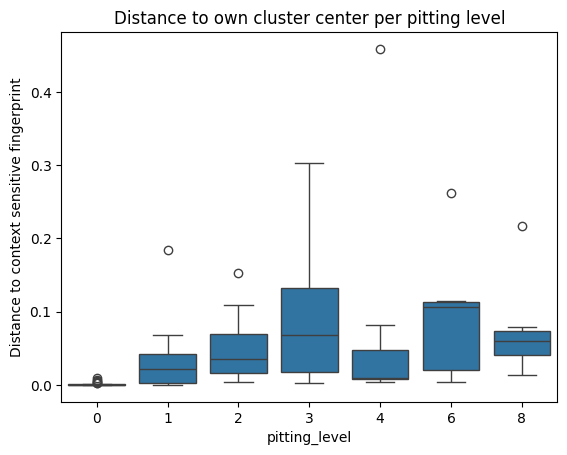

In [18]:
ax = sns.boxplot(data=df_cosine, y='distance_to_own_cluster_center', x='pitting_level')
ax.set_ylabel('Distance to context sensitive fingerprint')
ax.set_title(f'Distance to own cluster center per pitting level');

In the boxplots above, a clear difference in terms of offset between healthy and faulty gearboxes can be observed. Indeed, healthy gearboxes, the one with pitting level = 0, have offset close to 0 wherease faulty gearbox, the one with pitting level above 0, have higher offset. This is expected, as the context-sensitive fingerprint is derived from healthy data without pitting and data with pitting is likely to have vibration patterns not present in the healthy data set.

The boxplot provides only a partial view of the ability of the methodology to identify anomalies. To fully appreciate the performance of the methodology, it is necessary to adequately detect faulty gearboxes as anomalies.
Whether a datapoint is labelled as anomalous depends on a predefined distance threshold.
If the predefined distance threshold is exceeded, an anomaly is raised.
To make our validation independent of the choice of this hyperparameter, we construct a ROC-curve by varying this distance threshold.

A ROC curve is a visualisation for evaluating the performance of the anomaly detection. It plots the *true positive rate* (TPR) against the *false positive rate (FPR)* at different distance thresholds. In this use case, the TPR represents the rate of measurements exposed to pitting that were actually detected as anomaly whereas the FPR is the rate of measurements that were not exposed to pitting and still detected as anomaly.
The higher is the area under the ROC-curve, the better the model is at detecting anomalies.

Below the ROC-curve is plotted.

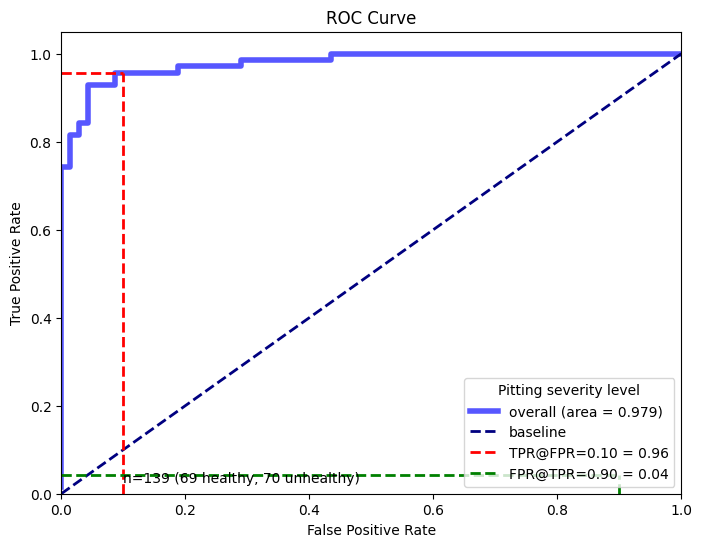

In [19]:
plot_ROC_curve(df_cosine)

In the figure above it can be observed that the anomaly detection generally performs well with an area under the curve (AUC) of 0.979.
Operators aim for a high TPR while minimizing false alarms (keeping the FPR low). Therefore, we additionally tracked the TPR at a stable FPR of 0.1 (TPR@FPR=0.1, red dashed line), which represents the TPR when there are 10% false positives. In this scenario, the TPR would be 96%. An alternatve objective criterium is to keep the FPR as low as possible at a high TPR.
The plot above therefore also illustrates the FPR@TPR=0.9 (green dashed line).In that scenario, we check how many false alarms would be triggered if we want to guarantee that 90% of the gear pitting is detected. In this use case, FPR@TPR=0.9 is 0.04.

## 4. Conclusions

In this SK is illustrated a data-driven methodology for contextual performance profiling and anomaly detection. The SK focuses on how to set up methodology parameters and correctly interpret its results. The methodology, validated on a gearbox that is subject to pitting, explains how to extract the contexts from an asset and how to use them to profile its performance. Furthermore, it proves that the performance profiles can be used to identify anomalies. For the latter, it has been shown that our method is able to detect most anomalies, while throwing few false alarms, as demonstrated through the ROC curve.

# Additional information
The methodology presented in this notebook is based on the papers [[1]](#fingerhut2023) and [[2]](#fingerhut2024).

This Starter Kit was developed in the context of the Compact project [ToDo: Find an online reference]. For more information, please contact [info@elucidata.be](mailto:info@elucidata.be).

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Notebook"), to deal in the Notebook without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Notebook, and to permit persons to whom the Notebook is provided to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies of the Notebook and/or copies of substantial portions of the Notebook.

THE NOTEBOOK IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NON-INFRINGEMENT. IN NO EVENT SHALL SIRRIS, THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, DIRECT OR INDIRECT, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE NOTEBOOK OR THE USE OR OTHER DEALINGS IN THE NOTEBOOK

# References

<a id='fingerhut2023'>[1]</a> F. Fingerhut, S. Klein, M. Verbeke, S. Rajendran and E. Tsiporkova, "Multi-view contextual performance profiling in rotating machinery," 2023 IEEE International Conference on Prognostics and Health Management (ICPHM), Montreal, QC, Canada, 2023, pp. 343-350, [doi: 10.1109/ICPHM57936.2023.10194172](https://ieeexplore.ieee.org/document/10194172).

<a id='fingerhut2024'>[2]</a> F. Fingerhut, M. Verbeke and E. Tsiporkova, "Unsupervised context-sensitive anomaly detection on streaming data relying on multi-view profiling," 2024 IEEE International Conference on Evolving and Adaptive Intelligent Systems (EAIS), Madrid, Spain, 2024, pp. 1-10, [doi: 10.1109/EAIS58494.2024.10569106](https://ieeexplore.ieee.org/document/10569106).

<a id='nmf'>[3]</a> D. Lee, S. Seung, [“Learning the parts of objects by non-negative matrix factorization”](https://www.cs.columbia.edu/~blei/fogm/2020F/readings/LeeSeung1999.pdf), 1999

#### ©, 2024, Sirris